In [1]:
import pandas as pd
import numpy as np
import os

In [2]:
os.chdir(r'C:\SML_Projects\SML_CVE_type_cwe_predict')

In [3]:
df = pd.read_csv("data/engineered/engineered_dataset.csv")

In [4]:
df = df.sample(frac=0.1, random_state=42).reset_index(drop=True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10296 entries, 0 to 10295
Data columns (total 29 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   cve_id                      10296 non-null  object 
 1   description                 10296 non-null  object 
 2   cvss_score                  10296 non-null  object 
 3   cwe                         10296 non-null  object 
 4   vendor                      10296 non-null  object 
 5   product                     10296 non-null  object 
 6   publish_date                10296 non-null  object 
 7   type                        10296 non-null  object 
 8   vendor_freq                 10296 non-null  float64
 9   product_freq                10296 non-null  float64
 10  desc_len                    10296 non-null  int64  
 11  desc_word_count             10296 non-null  int64  
 12  desc_num_count              10296 non-null  int64  
 13  desc_upper_ratio            102

# Shap value

In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import shap

C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
from sklearn.preprocessing import OrdinalEncoder

df_copy = df.copy()

X = df_copy.drop(columns=['type', 'cvss_score'], errors='ignore')
y = df_copy[['type', 'cvss_score']]  

In [8]:
cat_cols = X.select_dtypes(exclude=[np.number]).columns
enc = OrdinalEncoder()
X[cat_cols] = enc.fit_transform(X[cat_cols])

feature_names = X.columns.tolist()

In [9]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [10]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.multioutput import MultiOutputClassifier


model = MultiOutputClassifier(
    ExtraTreesClassifier(random_state=42)
)

In [11]:
model.fit(x_train, y_train)

# y_train_pred = model.predict(x_train)
# y_test_pred = model.predict(x_test)

,estimator,ExtraTreesCla...ndom_state=42)
,n_jobs,None
,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0


In [12]:
# print("Train R²:", r2_score(y_train, y_train_pred))
# print("Test R²:", r2_score(y_test, y_test_pred))

In [13]:
from sklearn.metrics import accuracy_score

y_pred = model.predict(x_test)

print("Type accuracy:       ", accuracy_score(y_test['type'], y_pred[:, 0]))
print("CVSS_Score accuracy: ", accuracy_score(y_test['cvss_score'], y_pred[:, 1]))

Type accuracy:        0.9122693428293946
CVSS_Score accuracy:  0.693752023308514


# SHAP

In [14]:
for i, target in enumerate(['type', 'cvss_score']):
    clf = model.estimators_[i]
    print(f"\nFeature importances for target: {target}")
    for name, imp in zip(feature_names, clf.feature_importances_):
        print(f"{name:20s} = {imp:.5f}")


Feature importances for target: type
cve_id               = 0.02043
description          = 0.03006
cwe                  = 0.15378
vendor               = 0.01822
product              = 0.01746
publish_date         = 0.02098
vendor_freq          = 0.02912
product_freq         = 0.02888
desc_len             = 0.02187
desc_word_count      = 0.02147
desc_num_count       = 0.01765
desc_upper_ratio     = 0.02133
desc_exclamation     = 0.00038
desc_question        = 0.00125
vendor_product_interaction = 0.03240
XSS_score            = 0.17693
SQLi_score           = 0.10919
RCE_score            = 0.06786
DoS_score            = 0.06415
CSRF_score           = 0.03662
AuthBypass_score     = 0.01118
PrivEsc_score        = 0.01795
PathTraversal_score  = 0.02974
SSRF_score           = 0.00489
InfoDisclosure_score = 0.01603
Other_score          = 0.00201
cvss_keywords_score  = 0.02815

Feature importances for target: cvss_score
cve_id               = 0.06179
description          = 0.07489
cwe          

In [15]:
i = 0  # target index
clf = model.estimators_[i]
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(x_test)

sample_ind = 0
shap.plots.waterfall(
    shap.Explanation(
        values=shap_values[sample_ind],
        base_values=explainer.expected_value,
        data=x_test.iloc[sample_ind],
        feature_names=feature_names
    )
)

ValueError: The waterfall plot can currently only plot a single explanation, but a matrix of explanations (shape (27, 11)) was passed! Perhaps try `shap.plots.waterfall(shap_values[0])` or for multi-output models, try `shap.plots.waterfall(shap_values[0, 0])`.

In [ ]:
target_feature = "vendor"
for i, target in enumerate(['type', 'cvss_score']):
    clf = model.estimators_[i]
    explainer = shap.TreeExplainer(clf)
    shap_values = explainer(x_test)
    sv = shap_values.values if not isinstance(shap_values.values, list) else shap_values.values[i] 
    
    shap.dependence_plot(
        target_feature,
        sv,
        x_test,
        feature_names=x_test.columns
    )

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 11 and the array at index 1 has size 50

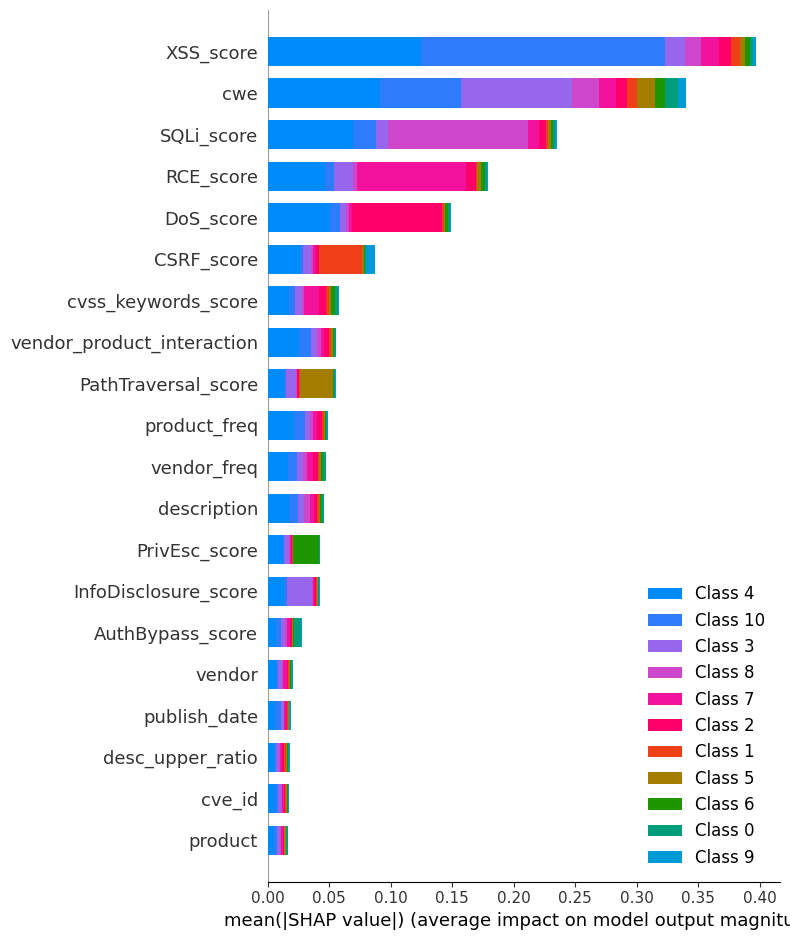

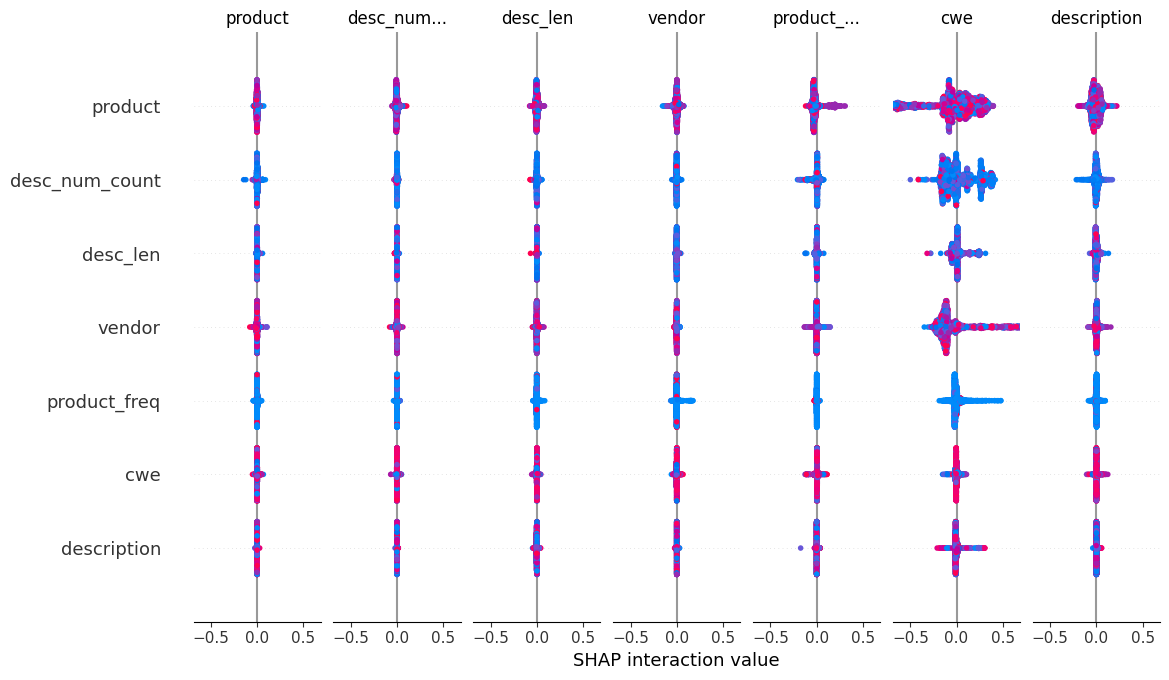

In [ ]:
i = 0
clf = model.estimators_[i]
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(x_test)

shap.summary_plot(shap_values, x_test, feature_names=feature_names, plot_type="bar")   
shap.summary_plot(shap_values, x_test, feature_names=feature_names) 

In [ ]:
print("\nFeature importances:\n")
clf = model.estimators_[0]
for name, importance in zip(X.columns, clf.feature_importances_):
    print(f"{name:20s} = {importance:.5f}")


Feature importances:

cve_id               = 0.02043
description          = 0.03006
cwe                  = 0.15378
vendor               = 0.01822
product              = 0.01746
publish_date         = 0.02098
vendor_freq          = 0.02912
product_freq         = 0.02888
desc_len             = 0.02187
desc_word_count      = 0.02147
desc_num_count       = 0.01765
desc_upper_ratio     = 0.02133
desc_exclamation     = 0.00038
desc_question        = 0.00125
vendor_product_interaction = 0.03240
XSS_score            = 0.17693
SQLi_score           = 0.10919
RCE_score            = 0.06786
DoS_score            = 0.06415
CSRF_score           = 0.03662
AuthBypass_score     = 0.01118
PrivEsc_score        = 0.01795
PathTraversal_score  = 0.02974
SSRF_score           = 0.00489
InfoDisclosure_score = 0.01603
Other_score          = 0.00201
cvss_keywords_score  = 0.02815


In [ ]:
sample_ind = 15
clf = model.estimators_[0]  
explainer = shap.TreeExplainer(clf)
shap_values = explainer(x_test)
sv_class = shap_values.values[0] if isinstance(shap_values.values, list) else shap_values.values
base_val = explainer.expected_value if not isinstance(explainer.expected_value, list) else explainer.expected_value[i]

shap.plots.waterfall(
    shap.Explanation(
        values=sv_class[sample_ind],
        base_values=base_val[sample_ind],
        data=x_test.iloc[sample_ind],
        feature_names=feature_names
    ),
    max_display=14
)